# Assignment 1, Task B: Regression using tree methods.

## The data:
In this QSAR exercise, water solubility of various molecules is to be investigated. The dataset in use is the ESOL Dataset assembled by John Delaney, as provided here: https://huggingface.co/datasets/scikit-fingerprints/MoleculeNet_ESOL/tree/main.


## The tasks:
1) Inspect the data and clean if needed. Adhere to good practices!
2) Calculate some molecular descriptors via the smiles strings using rdkit (partial snippet provided)
3) Create a feature matrix X and a target vector y
4) Three different models should be trained on the molecular descriptors and evaluated according to RMSE and their R2 score to compare their performance. For each model, additionally, the overfitting needs to be addressed.

These three models have to be compared:
- `DecisionTreeClassifier`
- `RandomForestClassifier`
- `GradientBoostingClassifier`

For a first baseline performance, the models can be used as provided by `scikit`, but should include a random seed. 

5) Based on the model performance, take the best performing algorithm and optimise its hyperparameters using `GridSearchCV`

6) Assess the feature importance

7) Conclusion and discussion: Provide answers to the questions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import Descriptors

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
df = pd.read_csv("esol.csv")
df.head()

,SMILES,label
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77
1,Cc1occc1C(=O)Nc2ccccc2,-3.30
2,CC(C)=CCCC(C)=CC(=O),-2.06
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87
4,c1ccsc1,-1.33


## 1. Inspect and clean the data
Gain some overview of the data and assess NaNs and duplicates and clean if needed.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SMILES  1128 non-null   object 
 1   label   1128 non-null   float64
dtypes: float64(1), object(1)
memory usage: 17.8+ KB


In [4]:
df.isna().sum()

SMILES    0
label     0
dtype: int64

In [5]:
df.duplicated().sum()

np.int64(0)

In [6]:
df.describe()

,label
count,1128.000000
mean,-3.050102
std,2.096441
min,-11.600000
25%,-4.317500
50%,-2.860000
75%,-1.600000
max,1.580000


## 2. Create molecular descriptors from the Smiles
Use the snippet below to calculate descriptors from the SMILES strings. Make sure to include the molecular weight, the logP and choose three more which you believe to impact the solubility, e.g. https://greglandrum.github.io/rdkit-blog/posts/2022-12-23-descriptor-tutorial.html or here: https://deepwiki.com/rdkit/rdkit/6.1-molecular-descriptors-and-properties 

In [8]:
def compute_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "TPSA":              Descriptors.TPSA(mol),
        "NumHDonors":        Descriptors.NumHDonors(mol),
        "NumRotatableBonds": Descriptors.NumRotatableBonds(mol)
    })

# Apply to dataframe
descriptor_df = df["SMILES"].apply(compute_descriptors)

# Combine descriptors with original data
df_full = pd.concat([df, descriptor_df], axis=1)

# Remove rows where descriptor calculation failed
df_full = df_full.dropna()
df_full.head()

,SMILES,label,MolWt,LogP,TPSA,NumHDonors,NumRotatableBonds
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,-0.77,457.432,-3.10802,202.32,7.0,7.0
1,Cc1occc1C(=O)Nc2ccccc2,-3.30,201.225,2.84032,42.24,1.0,2.0
2,CC(C)=CCCC(C)=CC(=O),-2.06,152.237,2.87800,17.07,0.0,4.0
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,-7.87,278.354,6.29940,0.00,0.0,0.0
4,c1ccsc1,-1.33,84.143,1.74810,0.00,0.0,0.0


## 3. Create the feature matrix and target vector

In [10]:
X = df_full[["MolWt", "LogP", "TPSA", "NumHDonors", "NumRotatableBonds"]]
y = df_full["label"]

## 4. Train the models
Use a classic train-test split of 0.2 including a random seed. For training and predicting labels, take note of the time the process takes for each model (does not necessarily have to be coded, can also be estimated). Make sure to predict labels for both training and test splits in order to identify overfitting. Use the RMSE and R2 as metrics for evaluation of the baseline performance of the models. Make sure to consider overfitting.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [13]:
print("Training samples:", X_train.shape[0])
print("Test samples:    ", X_test.shape[0])

Training samples: 902
Test samples:     226


In [16]:
models = {
    "Decision Tree":     DecisionTreeRegressor(random_state=42),
    "Random Forest":     RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

results = []

for name, model in models.items():
    start = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start

    for split, X_s, y_s in [("Train", X_train, y_train), ("Test", X_test, y_test)]:
        y_pred = model.predict(X_s)
        results.append({
            "Model":   name,
            "Split":   split,
            "RMSE":    round(np.sqrt(mean_squared_error(y_s, y_pred)), 3),
            "R²":      round(r2_score(y_s, y_pred), 3),
            "Time(s)": round(elapsed, 3)
        })

pd.DataFrame(results)

,Model,Split,RMSE,R²,Time(s)
0,Decision Tree,Train,0.118,0.997,0.007
1,Decision Tree,Test,1.041,0.771,0.007
2,Random Forest,Train,0.279,0.982,0.103
3,Random Forest,Test,0.830,0.854,0.103
4,Gradient Boosting,Train,0.529,0.935,0.053
5,Gradient Boosting,Test,0.845,0.849,0.053


Use the best model and plot the predictions over the true values (y_test vs. y_pred) in a scatterplot.

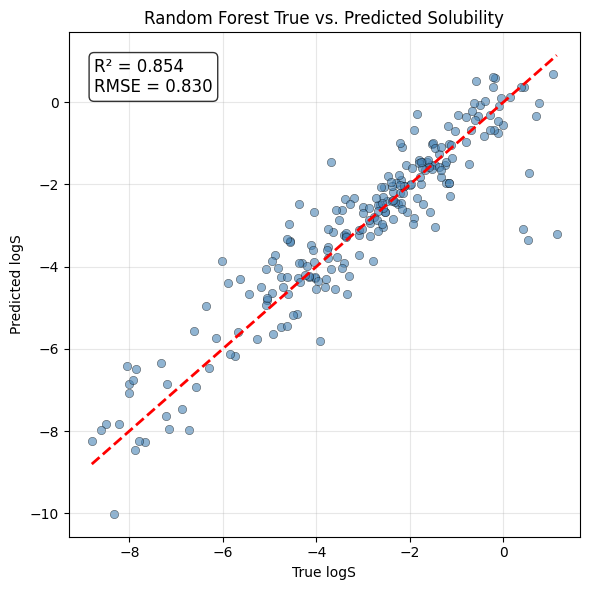

In [31]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='steelblue', edgecolors='k', linewidths=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True logS")
plt.ylabel("Predicted logS")
plt.title("Random Forest True vs. Predicted Solubility")
plt.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.3f}',
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Hyperparameter tuning of the best model
Use GridSearchCV to optimise the hyperparameters for the best model. Use a reasonable parameter grid (2-3 different values max. for each parameter you want to optimise).

In [36]:
param_grid = {
    "n_estimators":      [50, 100, 200],
    "learning_rate":     [0.05, 0.1, 0.2],
    "max_depth":         [3, 5, 7],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf":  [1, 3, 5]
}

grid_search = GridSearchCV(
    GradientBoostingRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

print("Best params:", grid_search.best_params_)
print(f"Test R²:     {r2_score(y_test, y_pred_best):.3f}")
print(f"Test RMSE:   {np.sqrt(mean_squared_error(y_test, y_pred_best)):.3f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best params: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Test R²:     0.851
Test RMSE:   0.838


Extract the best model

In [34]:
best_model = grid_search.best_estimator_

print("Best Parameters:")
print(grid_search.best_params_)

Best Parameters:
{'learning_rate': 0.05, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}


Useful tool: Export (and reimport) your best model:

In [35]:
import joblib
# export the best model:
joblib.dump(best_model, "best_model.joblib")
# reload the best model:
loaded_model = joblib.load("best_model.joblib")

Evaluate the best model on the test set.

In [38]:
# Evaluate tuned model
y_pred_best = best_model.predict(X_test)
r2_best   = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"Test R²:   {r2_best:.3f}")
print(f"Test RMSE: {rmse_best:.3f}")

Test R²:   0.851
Test RMSE: 0.838


Plot the predicted vs. the true solubility again!

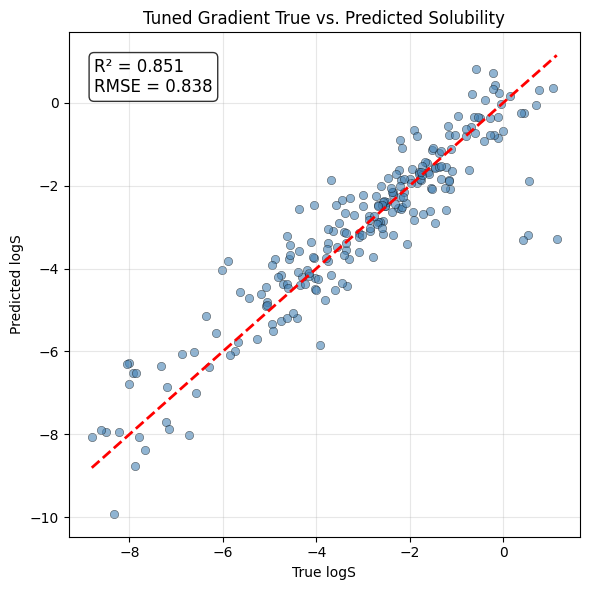

In [40]:
# Plot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_best, alpha=0.6, color='steelblue', edgecolors='k', linewidths=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel("True logS")
plt.ylabel("Predicted logS")
plt.title("Tuned Gradient True vs. Predicted Solubility")
plt.text(0.05, 0.95, f'R² = {r2_best:.3f}\nRMSE = {rmse_best:.3f}',
         transform=plt.gca().transAxes, fontsize=12,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Feature importance
Investigate the feature importance for your best model using the snippet below (but with your descriptors).

In [ ]:
feature_names = [
    "MolWt", "LogP"
]

importances = best_model.feature_importances_

for name, imp in sorted(zip(feature_names, importances), key=lambda x: -x[1]):
    print(f"{name}: {imp:.3f}")

## 7. Conclusion and discussion
- Which model performed the best?
- Which model showed the worst overfitting?
- Did the GridSearchCV improve the model? Is the difference to be considered significant?
- Which descriptors (besides the logP) had the most influence on the solubility?
